<a href="https://colab.research.google.com/github/kyubin-l/urop/blob/main/noise_car_damper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelling Additional Output Noise and Car Damper Data

A new model is created and trained in this script - the  nonlinear damping case with additional output noise is considered.

There is also an initial attempt at training the model with real-life car damper data. 

In [ ]:
# Connect to Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/urop_copy')
os.getcwd()

'/content/gdrive/MyDrive/urop_copy'

In [ ]:
# Import packages
import tensorflow as tf
import numpy as np
import math
from scipy.io import loadmat
import matplotlib.pyplot as plt


from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Layer, Softmax, Conv1D, Add

In [ ]:
# Running python files with functions

%run './CNNfunctions.py'
%run './mcoherence.py'

# Defining Model

In [ ]:
# Using the benchmark model which gave best results for benchmark results
# layers: 7, skip: 1, kernel width: 3, activation=tanh, layers in factors of 4

# Define optimization settings
Data = {'stem' : './duffing_data/output_noise/damping_noise_',
        'train_files' : [1,3,4,6,7,9,11,5,10,15,20],#list(range(1,5)),
        'test_files' : [2,8,13,16,19],
        'val_files' : [12,14,17,18], 
        'model_save_path' : './saved_models/noisy_output_model_1',
        'sampling_frequency' : 4096}  # 2**12

Opt = {'window_length' : 2**13,
       'freq_range' : np.array([1,200]), # Setting the frequency to the nyquist frequency isn't that good because a lot of data points with unit coherence at high frequency
       'learning_rate' : 0.005,
       'num_epochs' : 100,
       'causality' : 1000,
       'batch_size' : 2} #len(Data['train_files'])}

In [ ]:
# Define network hyperparameters

Hpar = {'layers' : 7,
        'skips' : 1,
        'activation' : 'tanh',
        'kernel_width' :3}

Hpar['channels'] = np.array([i*4 for i in range(1,Hpar['layers'])])
# Hpar['channels'] = np.array([8, 16, 24, 32, 40, 24, 32, 16, 24, 8])
#Hpar['channels'] = np.array([8,8,8,40,8,40,40,16,16])
#Hpar['channels'] = np.ones((9),dtype='int32')*32

Opt['freq_ind'] = np.rint(Opt['freq_range'] / (Data['sampling_frequency'] / Opt['window_length'])).astype(int)



if Hpar['skips'] == 2:
  Hpar['receptive_field'] = Hpar['kernel_width']**(math.floor(Hpar['layers']/2)+1) - 1
else:
  Hpar['receptive_field'] = Hpar['kernel_width']**(Hpar['layers']-1)

print('Receptive field is {:.3f} s'.format(Hpar['receptive_field']/Data['sampling_frequency']))

Receptive field is 0.178 s


# Loading Data

In [ ]:
def LoadData(file_numbers, stem, receptive_field):

  for f in range(len(file_numbers)):

    filepath = '%(stem)s%(file_number)i.mat' % {"stem": stem, "file_number": file_numbers[f]}
    data = loadmat(filepath)

    x = data['x']
    F = data['F']
    x_noise = data['x_noise']
    noise_raw = data['noise']

    if f == 0:
      inputs = F[np.newaxis,:,:]
      output_nonoise = x[np.newaxis,receptive_field-1:,0]
      outputs = x_noise[np.newaxis,receptive_field-1:,0]
      noise = noise_raw[np.newaxis,receptive_field-1:,0]

    else:
      inputs = np.concatenate((inputs, F[np.newaxis,:,:]), axis=0)
      output_nonoise = np.concatenate((output_nonoise, x[np.newaxis,receptive_field-1:,0]), axis=0)
      outputs = np.concatenate((outputs, x_noise[np.newaxis,receptive_field-1:,0]), axis=0)
      noise = np.concatenate((noise, noise_raw[np.newaxis,receptive_field-1:,0]), axis=0)


  inputs = tf.constant(inputs, dtype='float32')
  output_nonoise = tf.constant(output_nonoise, dtype='float32')
  outputs = tf.constant(outputs, dtype='float32')
  noise = tf.constant(noise, dtype='float32')

  return inputs, outputs, output_nonoise, noise

In [ ]:
inputs, outputs, output_nonoise, noise = LoadData(Data['train_files'], Data['stem'], Hpar['receptive_field'])
val_inputs, val_outputs, val_output_nonoise, val_noise = LoadData(Data['val_files'], Data['stem'], Hpar['receptive_field'])
Hpar['input_shape'] = inputs[0,...].shape

Calculating Sxx
Calculating Syy
Calculating Syx
Calculating transfer function and coherence
Calculating Sxx
Calculating Syy
Calculating Syx
Calculating transfer function and coherence


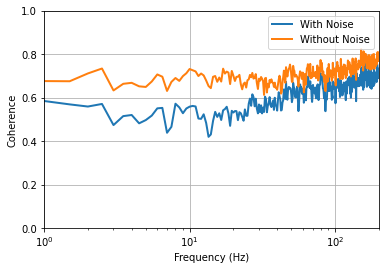

In [ ]:
# Plotting sample data point
F = inputs[0,Hpar['receptive_field']-1:,:]
x = outputs[0,:]
x_nonoise = output_nonoise[0,:]
noise = noise[0,:]

f, txf, cxf, sxf, sff, sxx = tfest(inputs=F, 
                                   outputs=x,
                                   win='hann',
                                   noverlap=int(Opt['window_length']/2),
                                   nperseg=Opt['window_length'],
                                   Fs=Data['sampling_frequency'])

f, txnf, cxnf, sxnf, sff, sxnxn = tfest(inputs=F,
                                       outputs=x_nonoise,
                                       win='hann',
                                       noverlap=int(Opt['window_length']/2),
                                       nperseg=Opt['window_length'],
                                       Fs=Data['sampling_frequency'])

PlotCoherence(f, np.concatenate((cxf[:,0,:], cxnf[:,0,:]), axis=0), Opt['freq_range'], ['With Noise', 'Without Noise'])

Calculating Sxx
Calculating Syy
Calculating Syx
Calculating transfer function and coherence


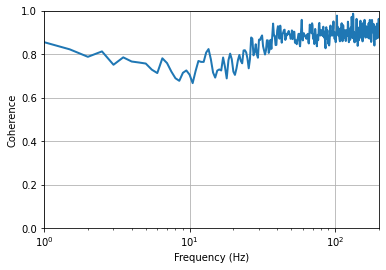

In [ ]:
# Nonlinearity due to the noise
f, tfn, cfn, sfn, sff, snn = tfest(inputs=F, 
                                   outputs=noise,
                                   win='hann',
                                   noverlap=int(Opt['window_length']/2),
                                   nperseg=Opt['window_length'],
                                   Fs=Data['sampling_frequency'])

cnonlin = np.real(sxnxn[:,0,:]/sxx[:,0,:])

PlotCoherence(f, np.real(sxnxn[:,0,:]/sxx[:,0,:]), Opt['freq_range'], []) # Measure of how much the coherence decreases due to the noise

# Initialising and Training Model

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs))
val_dataset = tf.data.Dataset.from_tensor_slices((val_inputs, val_outputs))

In [ ]:
model = BuildModel(Hpar)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 819201, 1)]  0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 819199, 4)    16          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 819193, 8)    104         conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 819193, 8)    72          input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
model.compile()
optimizer = tf.keras.optimizers.Adam(learning_rate=Opt['learning_rate'])

In [ ]:
results = TrainModel(model, optimizer, train_dataset, val_dataset, Opt, len(Data['train_files']) , Data['model_save_path']) # Include some sort of validation?

In [ ]:
model = tf.keras.models.load_model('./saved_models/noisy_output_model_1')

Training set performance --- Loss: 79.50569915771484, Cpy_avg: 0.800


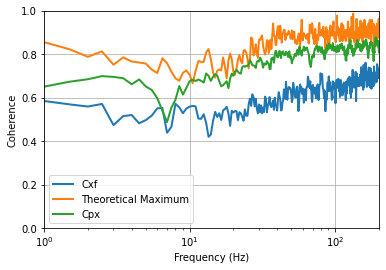

In [ ]:
loss, Cpy_avg, Cpy, Tpy = CoherenceLoss(model, val_inputs[1:3,:,:], val_outputs[1:3,:], Opt)

print('Training set performance --- Loss: {}, Cpy_avg: {:.3f}'.format(loss, Cpy_avg))

PlotCoherence(f, np.concatenate((cxf[0,:,:], cnonlin, Cpy[np.newaxis,:])), Opt['freq_range'], ['Cxf', 'Theoretical Maximum', 'Cpx'])

# Car Suspension Data

In [ ]:
# Define optimization settings
Data = {'stem' : './../UROP/Car suspension data/StrutChassis',
        'train_files' : [1,3,4,6,7,9,11,5,10,15,20],#list(range(1,5)),
        'test_files' : [2,8,13,16,19],
        'val_files' : [12,14,17,18], 
        'model_save_path' : './saved_models/car_suspension_model_1',
        'sampling_frequency' : 20000}  

Opt = {'window_length' : 2**13,
       'freq_range' : np.array([1,300]), # Test also [20, 300]
       'learning_rate' : 0.005,
       'num_epochs' : 100,
       'causality' : 1000,
       'batch_size' : 2} #len(Data['train_files'])}

In [ ]:
def LoadData(file_numbers, stem, receptive_field):

  for f in range(len(file_numbers)):

    filepath = '%(stem)s%(file_number)i.mat' % {"stem": stem, "file_number": file_numbers[f]}
    data = loadmat(filepath)

    x = data['x']
    F = data['y']
    x_allwheels = data['x_allwheels']

    # This experiment was displacement controlled. x as input, F as output

    if f == 0:
      inputs = x[np.newaxis,:,:]
      outputs = F[np.newaxis,:,:]
      allwheels = x_allwheels[np.newaxis,:,:]

    else:
      inputs = np.concatenate((inputs, x[np.newaxis,:,:]), axis=0)
      outputs = np.concatenate((outputs, F[np.newaxis,:,:]), axis=0)
      allwheels = np.concatenate((allwheels, x_allwheels[np.newaxis,:,:]), axis=0)


  x = tf.constant(inputs, dtype='float32')
  F = tf.constant(outputs, dtype='float32')
  x_allwheels = tf.constant(allwheels, dtype='float32')

  return x, F, x_allwheels

In [ ]:
# Define network hyperparameters

Hpar = {'layers' : 7,
        'skips' : 1,
        'activation' : 'tanh',
        'kernel_width' :4}

Hpar['channels'] = np.array([i*4 for i in range(1,Hpar['layers'])])
# Hpar['channels'] = np.array([8, 16, 24, 32, 40, 24, 32, 16, 24, 8])
#Hpar['channels'] = np.array([8,8,8,40,8,40,40,16,16])
#Hpar['channels'] = np.ones((9),dtype='int32')*32

Opt['freq_ind'] = np.rint(Opt['freq_range'] / (Data['sampling_frequency'] / Opt['window_length'])).astype(int)



if Hpar['skips'] == 2:
  Hpar['receptive_field'] = Hpar['kernel_width']**(math.floor(Hpar['layers']/2)+1) - 1
else:
  Hpar['receptive_field'] = Hpar['kernel_width']**(Hpar['layers']-1)

print('Receptive field is {:.3f} s'.format(Hpar['receptive_field']/Data['sampling_frequency']))

Receptive field is 0.205 s


In [ ]:
inputs, outputs, x_allwheels = LoadData(Data['train_files'], Data['stem'], Hpar['receptive_field'])
val_inputs, val_outputs, val_x_allwheels = LoadData(Data['val_files'], Data['stem'], Hpar['receptive_field'])
Hpar['input_shape'] = inputs[0,...].shape

In [ ]:
x = inputs[1,:,:]
F1 = outputs[1,:,0]
F2 = outputs[1,:,1]

# Average power spectrum for each data set, use mcoherence function
# Test how many datasets it takes
# THe value should be the btch size
# thesis pg 140

f, tfx, mcfx1, sfx, sxx, sff = tfest(inputs=x, 
                                   outputs=F1,
                                   win='hann',
                                   noverlap=int(Opt['window_length']/2),
                                   nperseg=Opt['window_length'],
                                   Fs=Data['sampling_frequency'])

f, tfx, mcfx2, sfx, sxx, sff = tfest(inputs=x, 
                                   outputs=F2,
                                   win='hann',
                                   noverlap=int(Opt['window_length']/2),
                                   nperseg=Opt['window_length'],
                                   Fs=Data['sampling_frequency'])

Calculating Sxx
Calculating Syy
Calculating Syx
Calculating transfer function and coherence
Calculating Sxx
Calculating Syy
Calculating Syx
Calculating transfer function and coherence


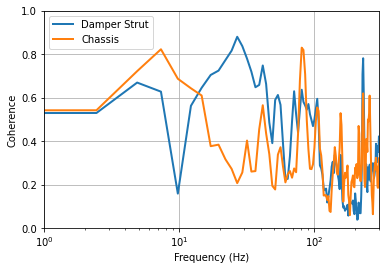

In [ ]:
PlotCoherence(f, np.concatenate((mcfx1[:,0], mcfx2[:,0])), [1, 300], ['Damper Strut', 'Chassis']) # Measure of how much the coherence decreases due to the noise

In [ ]:
# Modelling the damper strut only
outputs = outputs[:,Hpar['receptive_field']-1:,0]
val_outputs = val_outputs[:,Hpar['receptive_field']-1:,0]

# Modelling the chassis 
# outputs = outputs[:,:,1]
# val_outputs = val_outputs[:,:,1]

train_dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs))
val_dataset = tf.data.Dataset.from_tensor_slices((val_inputs, val_outputs))

In [ ]:
model = BuildModel(Hpar)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600000, 3)]  0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 599997, 4)    52          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 599985, 8)    136         conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 599985, 8)    384         input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
results = TrainModel(model, optimizer, train_dataset, val_dataset, Opt, len(Data['train_files']) , Data['model_save_path']) # Include some sort of validation?

Training set performance --- Loss: 127.19519805908203, Cpx_avg: 0.680
Validation set performance --- Loss: 156.63427734375, Cpx_avg: 0.606


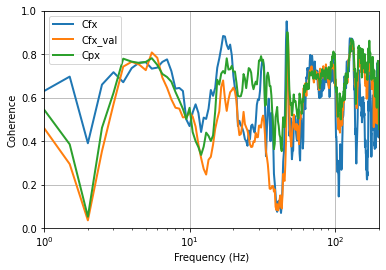

In [ ]:
loss, Cpy_avg, Cpy, Tpy = CoherenceLoss(model, inputs[7:10,:,:], outputs[7:10,:], Opt)
val_loss, val_Cpy_avg, val_Cpy, val_Tpy = CoherenceLoss(model, val_inputs[0:3,:,:], val_outputs[0:3,:], Opt)

print('Training set performance --- Loss: {}, Cpx_avg: {:.3f}'.format(loss, Cpy_avg))
print('Validation set performance --- Loss: {}, Cpx_avg: {:.3f}'.format(val_loss, val_Cpy_avg))

PlotCoherence(faxis, np.concatenate((mcfx1[0,:,:], val_Cpy[np.newaxis, :], Cpy[np.newaxis,:])), Opt['freq_range'], ['Cfx', 'Cfx_val', 'Cpx'])